In [3]:
import pandas as pd
import numpy as np
from plotly import express as px

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import pandas as pd

In [5]:
import os
import glob
from os import listdir
from os.path import isfile, join
cur_dir = os. getcwd()
print(cur_dir)
mypath = os.path.join(cur_dir, "..","backend-project", "data")
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]

c:\Users\liule\Desktop\ETH\Spring2023\AIIML\Project\b5-winning-in-basketball\dev_notebooks


In [6]:
files

['c:\\Users\\liule\\Desktop\\ETH\\Spring2023\\AIIML\\Project\\b5-winning-in-basketball\\dev_notebooks\\..\\backend-project\\data\\dataset_games.csv',
 'c:\\Users\\liule\\Desktop\\ETH\\Spring2023\\AIIML\\Project\\b5-winning-in-basketball\\dev_notebooks\\..\\backend-project\\data\\dataset_games_details.csv',
 'c:\\Users\\liule\\Desktop\\ETH\\Spring2023\\AIIML\\Project\\b5-winning-in-basketball\\dev_notebooks\\..\\backend-project\\data\\dataset_players.csv',
 'c:\\Users\\liule\\Desktop\\ETH\\Spring2023\\AIIML\\Project\\b5-winning-in-basketball\\dev_notebooks\\..\\backend-project\\data\\dataset_ranking.csv',
 'c:\\Users\\liule\\Desktop\\ETH\\Spring2023\\AIIML\\Project\\b5-winning-in-basketball\\dev_notebooks\\..\\backend-project\\data\\dataset_teams.csv']

In [7]:
dfs = {}
for file_path in files:
    dfs[file_path.split(".")[-2].split("\\")[-1]] = pd.read_csv(file_path)

C:\Users\liule\AppData\Local\Temp\ipykernel_12124\871462510.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[file_path.split(".")[-2].split("\\")[-1]] = pd.read_csv(file_path)


In [8]:
dfs.keys()

dict_keys(['dataset_games', 'dataset_games_details', 'dataset_players', 'dataset_ranking', 'dataset_teams'])

In [9]:
dfs["dataset_games_details"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668628 entries, 0 to 668627
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            668628 non-null  int64  
 1   TEAM_ID            668628 non-null  int64  
 2   TEAM_ABBREVIATION  668628 non-null  object 
 3   TEAM_CITY          668628 non-null  object 
 4   PLAYER_ID          668628 non-null  int64  
 5   PLAYER_NAME        668628 non-null  object 
 6   NICKNAME           53037 non-null   object 
 7   START_POSITION     255765 non-null  object 
 8   COMMENT            109689 non-null  object 
 9   MIN                558938 non-null  object 
 10  FGM                558938 non-null  float64
 11  FGA                558938 non-null  float64
 12  FG_PCT             558938 non-null  float64
 13  FG3M               558938 non-null  float64
 14  FG3A               558938 non-null  float64
 15  FG3_PCT            558938 non-null  float64
 16  FT

In [10]:
# the features we use for our prediction
PRED_COLS = ['AST', 'BLK', 'DREB', 'FG3A', 'FG3M', 'FGA', 'FGM', 'FTA', 'FTM', 'OREB', 'PF', 'STL', 'TO']

REGULAR_SEASON_DURATION = {
    2021: ('2021-10-19', '2022-04-10'),
    2020: ('2020-12-22', '2021-05-16'),
    2018: ('2018-10-16', '2019-04-10'),
    2017: ('2017-10-17', '2018-04-11'),
}


In [11]:
def get_season_games(season=2021):
    games = dfs['dataset_games'].copy()
    games = games[['TEAM_ID_home', 'TEAM_ID_away', 'HOME_TEAM_WINS', 'GAME_ID', 'GAME_DATE_EST']]
    
    regular_games = games[(REGULAR_SEASON_DURATION[season][0] <= pd.to_datetime(games['GAME_DATE_EST'])) & (pd.to_datetime(games['GAME_DATE_EST']) <= REGULAR_SEASON_DURATION[season][1])]
    
    return regular_games

def get_team_boxscore(team_id=1610612738, is_home=True):
    games = get_season_games(2021)
    games_details = dfs['dataset_games_details'].copy()
    # join games to games_details for date information
    games_details = games_details.merge(games, on='GAME_ID')

    # add additional column indicating whether team is home or not
    games_details['is_home'] = games_details['TEAM_ID'] == games_details['TEAM_ID_home']

    # select data from team at home or away
    games_details = games_details[(games_details['TEAM_ID']==team_id) & (games_details['is_home']==is_home)][PRED_COLS+['GAME_ID']]

    # sum over all players for each game and then average over all games
    boxscore = games_details.groupby(['GAME_ID']).sum().mean().to_frame().T
    
    return boxscore

def get_team_boxscore_by_position(team_id=1610612738, is_home=True, start_position = 'F'):
    games = get_season_games(2021)
    games_details = dfs['dataset_games_details'].copy()
    # join games to games_details for date information
    games_details = games_details.merge(games, on='GAME_ID')

    # add additional column indicating whether team is home or not
    games_details['is_home'] = games_details['TEAM_ID'] == games_details['TEAM_ID_home']

    # select data from team at home or away
    games_details = games_details[(games_details['TEAM_ID']==team_id) & (games_details['START_POSITION']==start_position) & (games_details['is_home']==is_home)][PRED_COLS+['GAME_ID', 'START_POSITION']]

    # sum over all players for each game and then average over all games
    boxscore = games_details.groupby(['GAME_ID']).sum().mean().to_frame().T
    
    return boxscore

In [12]:
get_season_games()

,TEAM_ID_home,TEAM_ID_away,HOME_TEAM_WINS,GAME_ID,GAME_DATE_EST
635,1610612751,1610612754,1,22101216,2022-04-10
636,1610612766,1610612764,1,22101217,2022-04-10
637,1610612739,1610612749,1,22101218,2022-04-10
638,1610612745,1610612737,0,22101221,2022-04-10
639,1610612763,1610612738,0,22101223,2022-04-10
...,...,...,...,...,...
1860,1610612762,1610612760,1,22100011,2021-10-20
1861,1610612756,1610612743,0,22100012,2021-10-20
1862,1610612757,1610612758,0,22100013,2021-10-20
1863,1610612749,1610612751,1,22100001,2021-10-19


In [13]:
box_score = get_team_boxscore()
box_score

,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO
0,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.0,7.463415,13.097561


In [14]:
F_box_score = get_team_boxscore_by_position(start_position='C')
F_box_score

,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO
0,2.487805,1.95122,5.97561,0.731707,0.243902,7.097561,4.853659,1.585366,1.121951,3.658537,2.243902,1.0,1.268293


In [15]:
def get_season_boxscore(season=2021):
    games = get_season_games(season)
    games_details = dfs['dataset_games_details'].copy()
    
    # add games details to regular season games
    games_details = games_details.merge(games, on='GAME_ID')

    # add additional column indicating whether team is home or not
    games_details['is_home'] = games_details['TEAM_ID'] == games_details['TEAM_ID_home']
    
    games_details = games_details[PRED_COLS + ['GAME_ID', 'TEAM_ID', 'is_home']]
    # group by game and team and sum stats
    games_details_agg = games_details.groupby(['GAME_ID', 'TEAM_ID']).sum()
    # reset is_home col to boolean value
    games_details_agg['is_home'] = games_details_agg['is_home'] > 0
    # group by team and is_home
    games_details_agg = games_details_agg.groupby(['TEAM_ID', 'is_home']).mean()
    # only keep prediction columns
    games_details_agg = games_details_agg[PRED_COLS]
    games_details_agg = games_details_agg.reset_index()
    return games_details_agg


def get_train_data(season=2021):
    season_games = get_season_games(season)
    games_details = get_season_boxscore(season)
    
    # add stats of home teams
    train_data = season_games.merge(games_details[games_details['is_home']].drop(columns='is_home'), left_on='TEAM_ID_home', right_on='TEAM_ID')
    # rename stats cols
    train_data = train_data.rename(columns={col: f"{col}_home" for col in PRED_COLS})
    # add stats of away teams
    train_data = train_data.merge(games_details[~games_details['is_home']].drop(columns='is_home'), left_on='TEAM_ID_away', right_on='TEAM_ID')
    # rename stats cols
    train_data = train_data.rename(columns={col: f"{col}_away" for col in PRED_COLS})
    
    # only return feature and target columns
    return train_data[[f"{col}_home" for col in PRED_COLS]+[f"{col}_away" for col in PRED_COLS]+['HOME_TEAM_WINS']]

In [16]:
get_season_boxscore()

,TEAM_ID,is_home,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO
0,1610612737,False,24.000000,3.878049,33.609756,33.634146,12.414634,89.585366,41.048780,20.829268,16.707317,10.731707,18.487805,6.512195,11.439024
1,1610612737,True,25.195122,4.609756,34.268293,35.170732,13.341463,87.024390,41.902439,23.780488,19.512195,9.341463,18.926829,7.804878,11.097561
2,1610612738,False,25.146341,5.975610,36.390244,38.560976,13.902439,87.536585,40.780488,21.268293,17.292683,10.146341,19.097561,6.951220,13.000000
3,1610612738,True,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.000000,7.463415,13.097561
4,1610612739,False,24.926829,4.121951,33.390244,31.658537,11.048780,84.560976,39.756098,21.902439,16.951220,10.195122,17.439024,6.853659,13.341463
5,1610612739,True,25.414634,4.243902,34.560976,33.853659,12.195122,84.707317,39.634146,22.243902,16.609756,10.219512,17.512195,7.292683,13.195122
6,1610612740,False,24.073171,4.000000,33.292683,30.682927,10.219512,87.024390,38.975610,24.414634,19.048780,11.780488,19.536585,8.512195,13.365854
7,1610612740,True,25.853659,4.000000,33.195122,33.439024,11.073171,88.878049,41.365854,22.000000,17.560976,12.146341,19.780488,8.073171,13.195122
8,1610612741,False,23.463415,4.121951,32.975610,29.097561,10.658537,85.658537,40.682927,20.829268,17.000000,8.024390,19.219512,7.317073,12.951220
9,1610612741,True,24.292683,4.073171,34.341463,28.560976,10.609756,88.170732,42.780488,22.243902,18.024390,9.317073,18.341463,6.951220,11.292683


In [17]:
get_train_data()

,AST_home,BLK_home,DREB_home,FG3A_home,FG3M_home,FGA_home,FGM_home,FTA_home,FTM_home,OREB_home,PF_home,STL_home,TO_home,AST_away,BLK_away,DREB_away,FG3A_away,FG3M_away,FGA_away,FGM_away,FTA_away,FTM_away,OREB_away,PF_away,STL_away,TO_away,HOME_TEAM_WINS
0,25.073171,5.707317,34.536585,31.121951,10.317073,88.439024,41.195122,21.926829,17.731707,10.975610,19.682927,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
1,25.073171,5.707317,34.536585,31.121951,10.317073,88.439024,41.195122,21.926829,17.731707,10.975610,19.682927,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
2,28.268293,5.560976,34.951220,38.707317,13.560976,91.317073,42.390244,20.926829,15.121951,11.390244,20.048780,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
3,28.268293,5.560976,34.951220,38.707317,13.560976,91.317073,42.390244,20.926829,15.121951,11.390244,20.048780,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
4,25.414634,4.243902,34.560976,33.853659,12.195122,84.707317,39.634146,22.243902,16.609756,10.219512,17.512195,7.292683,13.195122,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,27.219512,5.536585,32.219512,35.439024,12.317073,90.292683,43.000000,20.487805,15.902439,11.560976,20.121951,7.390244,13.512195,25.439024,5.219512,33.658537,32.341463,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,0
1226,22.634146,5.000000,35.170732,37.341463,12.341463,88.829268,38.926829,18.975610,14.463415,10.609756,18.609756,7.658537,13.317073,25.439024,5.219512,33.658537,32.341463,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,0
1227,23.756098,4.658537,33.195122,32.634146,11.658537,86.195122,40.048780,23.780488,18.560976,8.975610,19.195122,7.292683,13.756098,25.439024,5.219512,33.658537,32.341463,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,1
1228,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.000000,7.463415,13.097561,25.439024,5.219512,33.658537,32.341463,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,1


In [18]:
def calculate_advanced_stat(train_data):
    train_data_advanced = train_data.copy()
    for index, row in train_data_advanced.iterrows():
        
        # points
        points_home = 2 * (row["FGM_home"] + 0.5 * row["FG3M_home"]) + row["FTM_home"]
        points_away = 2 * (row["FGM_away"] + 0.5 * row["FG3M_away"]) + row["FTM_away"]
        train_data_advanced.loc[index, "Points_home"] = points_home
        train_data_advanced.loc[index, "Points_away"] = points_away

        # possession = .5 * (FGA + .475 * FTA - ORB + TOV)
        possessions_home = 0.5 * (row["FGA_home"] + 0.475 * row["FTA_home"] - row["OREB_home"] + row["TO_home"])
        possessions_away = 0.5 * (row["FGA_away"] + 0.475 * row["FTA_away"] - row["OREB_away"] + row["TO_away"])
        train_data_advanced.loc[index, "Possesions_home"] = possessions_home
        train_data_advanced.loc[index, "Possesions_away"] = possessions_away

        # Effective Field Goal Percentage (eFG%) = (FG + .5 * 3P) / FGA
        train_data_advanced.loc[index, "EFG%_home"] = (row["FGM_home"] + 0.5 * row["FG3M_home"]) / row["FGA_home"]
        train_data_advanced.loc[index, "EFG%_away"] = (row["FGM_away"] + 0.5 * row["FG3M_away"]) / row["FGA_away"]

        # True Shooting Percentage (TS%) = Pts / (2 * (FGA + .475 * FTA))
        train_data_advanced.loc[index, "TS%_home"] = points_home / (2 * (row["FGA_home"] + 0.475 * row["FTA_home"]))
        train_data_advanced.loc[index, "TS%_away"] = points_away / (2 * (row["FGA_away"] + 0.475 * row["FTA_away"]))

        # Turnover Percentage (TOV%) = TOV / (FGA + .475*FTA + AST + TOV)
        train_data_advanced.loc[index, "TOV%_home"] = row["TO_home"] / (row["FGA_home"] + 0.475 * row["FTA_home"] + row["TO_home"])
        train_data_advanced.loc[index, "TOV%_away"] = row["TO_away"] / (row["FGA_away"] + 0.475 * row["FTA_away"] + row["TO_away"])

        # Offensive Rating (OR) = 100 / (TmPoss + OppPoss) * Pts
        train_data_advanced.loc[index, "OR_home"] = (100 * points_home) / (possessions_home + possessions_away)
        train_data_advanced.loc[index, "OR_away"] = (100 * points_away) / (possessions_home + possessions_away)

        # Defensive Rating (DR) = 100 / (TmPoss + OppPoss) * OppPts
        train_data_advanced.loc[index, "DR_home"] = (100 * points_away) / (possessions_home + possessions_away)
        train_data_advanced.loc[index, "DR_away"] = (100 * points_home) / (possessions_home + possessions_away)

    return train_data_advanced

In [19]:
train_data = []
for season in REGULAR_SEASON_DURATION:
    train_data.append(get_train_data(season))
    
train_data = pd.concat(train_data, axis=0)

In [20]:
train_data_advanced = calculate_advanced_stat(train_data)

In [21]:
train_data_advanced

,AST_home,BLK_home,DREB_home,FG3A_home,FG3M_home,FGA_home,FGM_home,FTA_home,FTM_home,OREB_home,PF_home,STL_home,TO_home,AST_away,BLK_away,DREB_away,FG3A_away,FG3M_away,FGA_away,FGM_away,FTA_away,FTM_away,OREB_away,PF_away,STL_away,TO_away,HOME_TEAM_WINS,Points_home,Points_away,Possesions_home,Possesions_away,EFG%_home,EFG%_away,TS%_home,TS%_away,TOV%_home,TOV%_away,OR_home,OR_away,DR_home,DR_away
0,25.073171,5.707317,34.536585,31.121951,10.317073,88.439024,41.195122,21.926829,17.731707,10.975610,19.682927,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1,105.317073,107.341463,49.608537,51.425305,0.520703,0.518633,0.549798,0.550280,0.117531,0.132918,104.239403,106.243078,106.243078,104.239403
1,25.073171,5.707317,34.536585,31.121951,10.317073,88.439024,41.195122,21.926829,17.731707,10.975610,19.682927,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1,105.317073,107.341463,49.608537,51.425305,0.520703,0.518633,0.549798,0.550280,0.117531,0.132918,104.239403,106.243078,106.243078,104.239403
2,28.268293,5.560976,34.951220,38.707317,13.560976,91.317073,42.390244,20.926829,15.121951,11.390244,20.048780,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1,111.463415,107.341463,50.546341,51.425305,0.549383,0.518633,0.579537,0.550280,0.121049,0.132918,109.308243,105.265990,105.265990,109.308243
3,28.268293,5.560976,34.951220,38.707317,13.560976,91.317073,42.390244,20.926829,15.121951,11.390244,20.048780,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1,111.463415,107.341463,50.546341,51.425305,0.549383,0.518633,0.579537,0.550280,0.121049,0.132918,109.308243,105.265990,105.265990,109.308243
4,25.414634,4.243902,34.560976,33.853659,12.195122,84.707317,39.634146,22.243902,16.609756,10.219512,17.512195,7.292683,13.195122,23.536585,5.609756,32.926829,35.268293,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1,104.634146,107.341463,49.274085,51.425305,0.523911,0.518633,0.550922,0.550280,0.123580,0.132918,103.907428,106.595942,106.595942,103.907428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,24.560976,6.463415,34.731707,33.000000,12.024390,88.926829,41.804878,20.926829,16.536585,10.121951,20.902439,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,11.536585,84.121951,37.512195,20.804878,16.146341,9.390244,19.146341,7.634146,13.853659,1,112.170732,102.707317,50.555488,49.233841,0.537713,0.514497,0.567281,0.546291,0.111171,0.128444,112.407541,102.924148,102.924148,112.407541
1226,24.560976,6.463415,34.731707,33.000000,12.024390,88.926829,41.804878,20.926829,16.536585,10.121951,20.902439,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,11.536585,84.121951,37.512195,20.804878,16.146341,9.390244,19.146341,7.634146,13.853659,1,112.170732,102.707317,50.555488,49.233841,0.537713,0.514497,0.567281,0.546291,0.111171,0.128444,112.407541,102.924148,102.924148,112.407541
1227,19.951220,5.121951,33.926829,27.951220,9.000000,87.585366,38.414634,23.853659,17.341463,10.341463,22.463415,6.512195,15.097561,20.829268,3.853659,34.390244,29.975610,11.536585,84.121951,37.512195,20.804878,16.146341,9.390244,19.146341,7.634146,13.853659,0,103.170732,102.707317,51.835976,49.233841,0.489975,0.514497,0.521508,0.546291,0.132419,0.128444,102.078677,101.620167,101.620167,102.078677
1228,22.414634,4.707317,35.073171,43.317073,15.463415,84.731707,39.219512,26.658537,20.487805,9.292683,19.390244,8.926829,13.292683,20.829268,3.853659,34.390244,29.975610,11.536585,84.121951,37.512195,20.804878,16.146341,9.3902

In [84]:
PREDICTION_STATS = ['AST_home', 'BLK_home', 'DREB_home', "FG3A_home", "FGA_home", "FTA_home", 'OREB_home', 'STL_home', "TO_home", 
                    'AST_away', 'BLK_away', 'DREB_away', "FG3A_away", "FGA_away", "FTA_away", 'OREB_away', 'STL_away', "TO_away"] 

In [85]:
y = train_data_advanced["HOME_TEAM_WINS"]
X = train_data_advanced[PREDICTION_STATS]

In [86]:
X

,AST_home,BLK_home,DREB_home,FG3A_home,FGA_home,FTA_home,OREB_home,STL_home,TO_home,AST_away,BLK_away,DREB_away,FG3A_away,FGA_away,FTA_away,OREB_away,STL_away,TO_away
0,25.073171,5.707317,34.536585,31.121951,88.439024,21.926829,10.975610,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
1,25.073171,5.707317,34.536585,31.121951,88.439024,21.926829,10.975610,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
2,28.268293,5.560976,34.951220,38.707317,91.317073,20.926829,11.390244,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
3,28.268293,5.560976,34.951220,38.707317,91.317073,20.926829,11.390244,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
4,25.414634,4.243902,34.560976,33.853659,84.707317,22.243902,10.219512,7.292683,13.195122,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,24.560976,6.463415,34.731707,33.000000,88.926829,20.926829,10.121951,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1226,24.560976,6.463415,34.731707,33.000000,88.926829,20.926829,10.121951,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1227,19.951220,5.121951,33.926829,27.951220,87.585366,23.853659,10.341463,6.512195,15.097561,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1228,22.414634,4.707317,35.073171,43.317073,84.731707,26.658537,9.292683,8.926829,13.292683,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659


### Classification

In [87]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [88]:
from sklearn.model_selection import cross_val_score
import statistics

In [89]:
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

In [90]:
# using sklearn API

# Define the LightGBM model
model = lgb.LGBMClassifier(boosting_type='dart', num_leaves=1023, max_depth=10, learning_rate=0.01, n_estimators=50, min_child_samples=750, random_state=42, objective='binary')

model_ac = cross_val_score(model, X, y, cv=10, scoring="accuracy")
model_f1 = cross_val_score(model, X, y, cv=10, scoring="f1")

In [91]:
model.fit(X,y)

LGBMClassifier(boosting_type='dart', learning_rate=0.01, max_depth=10,
               min_child_samples=750, n_estimators=50, num_leaves=1023,
               objective='binary', random_state=42)

In [92]:
DATA_ROOT = os.path.join('..', 'backend-project', 'data')

In [93]:
import pickle
with open(os.path.join(DATA_ROOT, 'precomputed', 'classifier_new_stats.pkl'), 'wb') as f:
    pickle.dump(model, f)

In [94]:
with open(os.path.join(DATA_ROOT, 'precomputed', 'classifier_new_stats.pkl'), 'rb') as f:
    clf = pickle.load(f)

In [95]:
result=clf.predict_proba(X_test)[2]

In [96]:
result

array([0.46242164, 0.53757836])

In [97]:
X

,AST_home,BLK_home,DREB_home,FG3A_home,FGA_home,FTA_home,OREB_home,STL_home,TO_home,AST_away,BLK_away,DREB_away,FG3A_away,FGA_away,FTA_away,OREB_away,STL_away,TO_away
0,25.073171,5.707317,34.536585,31.121951,88.439024,21.926829,10.975610,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
1,25.073171,5.707317,34.536585,31.121951,88.439024,21.926829,10.975610,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
2,28.268293,5.560976,34.951220,38.707317,91.317073,20.926829,11.390244,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
3,28.268293,5.560976,34.951220,38.707317,91.317073,20.926829,11.390244,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
4,25.414634,4.243902,34.560976,33.853659,84.707317,22.243902,10.219512,7.292683,13.195122,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,24.560976,6.463415,34.731707,33.000000,88.926829,20.926829,10.121951,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1226,24.560976,6.463415,34.731707,33.000000,88.926829,20.926829,10.121951,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1227,19.951220,5.121951,33.926829,27.951220,87.585366,23.853659,10.341463,6.512195,15.097561,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1228,22.414634,4.707317,35.073171,43.317073,84.731707,26.658537,9.292683,8.926829,13.292683,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659


#### boosting

In [104]:
# using lightgbm API

# Set LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01,
}

# Convert the data into a LightGBM dataset object
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test)
lgb_cv_train = lgb.Dataset(X, y)

# Train the LightGBM model
num_boost_round = 500
model = lgb.train(params=params, train_set=lgb_train, num_boost_round=num_boost_round, valid_sets=[lgb_val], early_stopping_rounds=50)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred > 0.5)
f1score = f1_score(y_test, y_pred > 0.5)
print('Accuracy:', accuracy)
print('F1Score:', f1score)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 2148, number of negative: 1691
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559521 -> initscore=0.239217
[LightGBM] [Info] Start training from score 0.239217
[1]	valid_0's binary_logloss: 0.677981
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.677166
[3]	valid_0's binary_logloss: 0.676377
[4]	valid_0's binary_logloss: 0.675599
[5]	valid_0's binary_logloss: 0.674782
[6]	valid_0's binary_logloss: 0.674057
[7]	valid_0's binary_logloss: 0.673337
[8]	valid_0's binary_logloss: 0.672538
[9]	valid_0's binary_logloss: 0.671891
[10]	valid_0's binary_logloss: 0.671229
[11]	valid_0's binary_logloss: 0.670492
[12]	valid_0's b

In [99]:
# save booster to disk
model_string = model.model_to_string()

with open(os.path.join(DATA_ROOT, 'precomputed', 'classifier_new_stats.txt'), 'w') as f:
    f.write(model_string)

In [100]:
print("accuracy of 5-fold CV:")
print(statistics.mean(model_ac))

print("F1 of 5-fold CV:")
print(statistics.mean(model_f1))


accuracy of 5-fold CV:
0.5655345337508698
F1 of 5-fold CV:
0.7224805658648988


In [109]:
import shap
explainer = shap.TreeExplainer(model, data = X, model_output='probability', feature_names=X.columns)

In [110]:
X

,AST_home,BLK_home,DREB_home,FG3A_home,FGA_home,FTA_home,OREB_home,STL_home,TO_home,AST_away,BLK_away,DREB_away,FG3A_away,FGA_away,FTA_away,OREB_away,STL_away,TO_away
0,25.073171,5.707317,34.536585,31.121951,88.439024,21.926829,10.975610,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
1,25.073171,5.707317,34.536585,31.121951,88.439024,21.926829,10.975610,6.951220,14.365854,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
2,28.268293,5.560976,34.951220,38.707317,91.317073,20.926829,11.390244,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
3,28.268293,5.560976,34.951220,38.707317,91.317073,20.926829,11.390244,7.926829,13.341463,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
4,25.414634,4.243902,34.560976,33.853659,84.707317,22.243902,10.219512,7.292683,13.195122,23.536585,5.609756,32.926829,35.268293,88.682927,22.292683,11.000000,6.804878,13.731707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,24.560976,6.463415,34.731707,33.000000,88.926829,20.926829,10.121951,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1226,24.560976,6.463415,34.731707,33.000000,88.926829,20.926829,10.121951,7.439024,12.365854,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1227,19.951220,5.121951,33.926829,27.951220,87.585366,23.853659,10.341463,6.512195,15.097561,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659
1228,22.414634,4.707317,35.073171,43.317073,84.731707,26.658537,9.292683,8.926829,13.292683,20.829268,3.853659,34.390244,29.975610,84.121951,20.804878,9.390244,7.634146,13.853659


In [111]:
import pickle

# save tree explainer to disk
with open(os.path.join(DATA_ROOT, 'precomputed', 'TreeExplainer_new_stats.pkl'), 'wb') as f:
    pickle.dump(explainer, f)

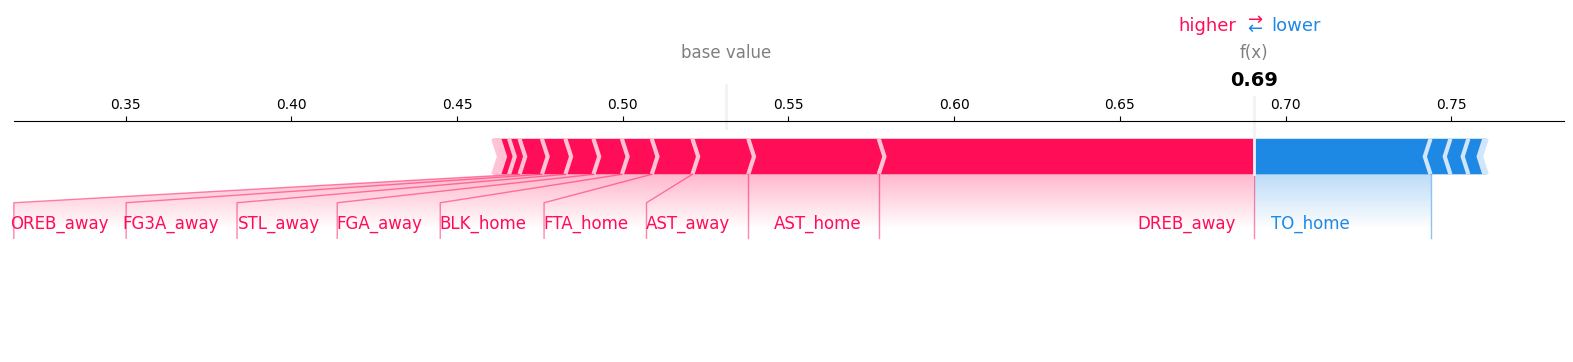

In [107]:


shap_values = explainer.shap_values(X.iloc[1].to_frame().T)
ind = 0
shap.force_plot(explainer.expected_value, shap_values[ind], text_rotation=0, matplotlib=True, feature_names=X.columns)

In [149]:
shap_values = shap.TreeExplainer(model).shap_values(X_test.iloc[0].to_frame().T)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


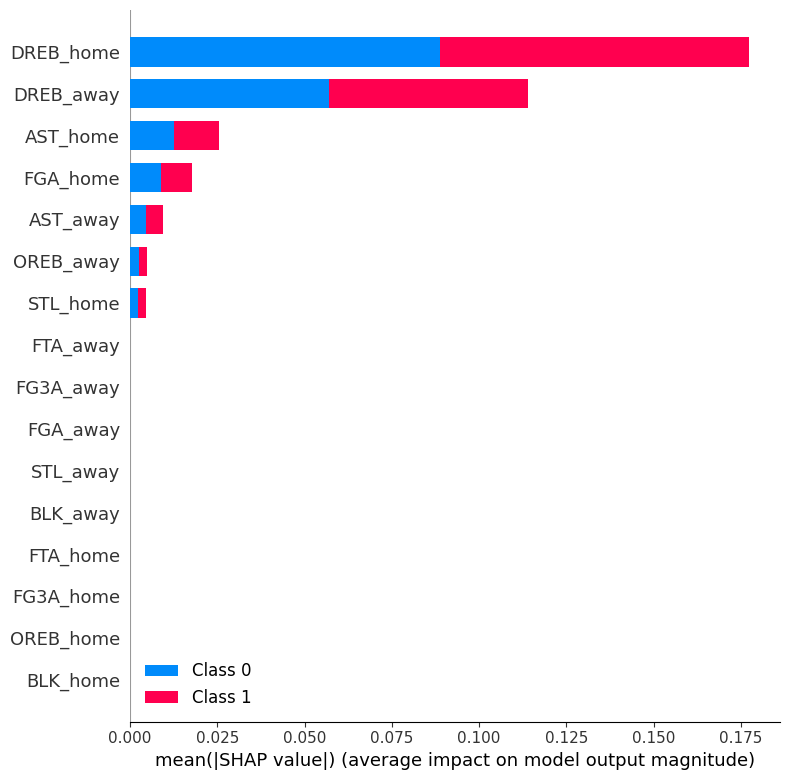

In [150]:
shap.summary_plot(shap_values, X_test.iloc[0].to_frame().T)

#### Clustering

In [51]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [52]:
teams_season = get_season_boxscore()
teams_season

,TEAM_ID,is_home,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO
0,1610612737,False,24.000000,3.878049,33.609756,33.634146,12.414634,89.585366,41.048780,20.829268,16.707317,10.731707,18.487805,6.512195,11.439024
1,1610612737,True,25.195122,4.609756,34.268293,35.170732,13.341463,87.024390,41.902439,23.780488,19.512195,9.341463,18.926829,7.804878,11.097561
2,1610612738,False,25.146341,5.975610,36.390244,38.560976,13.902439,87.536585,40.780488,21.268293,17.292683,10.146341,19.097561,6.951220,13.000000
3,1610612738,True,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.000000,7.463415,13.097561
4,1610612739,False,24.926829,4.121951,33.390244,31.658537,11.048780,84.560976,39.756098,21.902439,16.951220,10.195122,17.439024,6.853659,13.341463
5,1610612739,True,25.414634,4.243902,34.560976,33.853659,12.195122,84.707317,39.634146,22.243902,16.609756,10.219512,17.512195,7.292683,13.195122
6,1610612740,False,24.073171,4.000000,33.292683,30.682927,10.219512,87.024390,38.975610,24.414634,19.048780,11.780488,19.536585,8.512195,13.365854
7,1610612740,True,25.853659,4.000000,33.195122,33.439024,11.073171,88.878049,41.365854,22.000000,17.560976,12.146341,19.780488,8.073171,13.195122
8,1610612741,False,23.463415,4.121951,32.975610,29.097561,10.658537,85.658537,40.682927,20.829268,17.000000,8.024390,19.219512,7.317073,12.951220
9,1610612741,True,24.292683,4.073171,34.341463,28.560976,10.609756,88.170732,42.780488,22.243902,18.024390,9.317073,18.341463,6.951220,11.292683


In [63]:
def calculate_ratings(boxscore): 
    boxscore_ratings = boxscore.copy()
    for index, row in boxscore_ratings.iterrows():
        boxscore_ratings.loc[index, "point"] = 2 * (row["FGM"] + 0.5 * row["FG3M"]) + row["FTM"]
        boxscore_ratings.loc[index, "possession"] = 0.5 * (row["FGA"] + 0.475 * row["FTA"] - row["OREB"] + row["TO"])
    
    mean_possession = boxscore_ratings["possession"].mean()

    for index, row in boxscore_ratings.iterrows():
        # Offensive Rating (OR) = 100 / (TmPoss + OppPoss) * Pts
        boxscore_ratings.loc[index, "OR"] = (100 * row["point"]) / (row["possession"] + mean_possession)
        
        boxscore_ratings.loc[index, "DR"] = 100 * (row["BLK"] + row["DREB"] + row["STL"]) / (row["possession"] + mean_possession)

    boxscore_ratings.drop("is_home", axis =1 ,inplace= True)
    return boxscore_ratings.groupby("TEAM_ID",as_index=False).mean()
        

In [64]:
teams_season_rating = calculate_ratings(teams_season)

In [65]:
teams_season_rating 

,TEAM_ID,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO,point,possession,OR,DR
0,1610612737,24.597561,4.243902,33.939024,34.402439,12.878049,88.304878,41.475610,22.304878,18.109756,10.036585,18.707317,7.158537,11.268293,113.939024,50.065701,113.183788,45.040991
1,1610612738,24.829268,5.829268,35.548780,37.121951,13.231707,87.402439,40.743902,20.890244,17.036585,10.524390,18.548780,7.207317,13.048780,111.756098,49.924848,111.168100,48.328792
2,1610612739,25.170732,4.182927,33.975610,32.756098,11.621951,84.634146,39.695122,22.073171,16.780488,10.207317,17.475610,7.073171,13.268293,107.792683,49.089939,108.125442,45.371079
3,1610612740,24.963415,4.000000,33.243902,32.060976,10.646341,87.951220,40.170732,23.207317,18.304878,11.963415,19.658537,8.292683,13.280488,109.292683,50.145884,108.480270,45.198570
4,1610612741,23.878049,4.097561,33.658537,28.829268,10.634146,86.914634,41.731707,21.536585,17.512195,8.670732,18.780488,7.134146,12.121951,111.609756,50.297866,110.612680,44.489536
5,1610612742,23.390244,3.963415,33.768293,37.353659,13.085366,85.158537,39.292683,21.207317,16.353659,9.268293,19.658537,6.731707,11.707317,108.024390,48.835518,108.637555,44.713930
6,1610612743,27.792683,3.719512,34.939024,35.902439,12.670732,86.329268,41.658537,21.036585,16.731707,9.170732,19.987805,7.219512,13.841463,112.719512,50.496189,111.490487,45.381172
7,1610612744,27.109756,4.536585,35.731707,39.402439,14.341463,86.426829,40.524390,20.304878,15.609756,9.756098,21.012195,8.768293,14.317073,111.000000,50.316311,109.985897,48.587145
8,1610612745,23.560976,4.658537,32.439024,38.658537,13.475610,86.378049,39.378049,24.512195,17.487805,9.585366,20.634146,7.317073,15.658537,109.719512,52.047256,106.885313,43.268378
9,1610612746,24.012195,4.951220,34.878049,34.170732,12.768293,87.439024,40.060976,19.585366,15.524390,9.109756,18.634146,7.414634,13.024390,108.414634,50.328354,107.417461,46.808273


In [56]:
CLUSTERING_PRED = ["OR", "DR"]

In [57]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(teams_season_rating[CLUSTERING_PRED])

# add clustering columns
teams_season_rating['cluster'] = kmeans.labels_

In [60]:
teams_season_rating

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [58]:
px.scatter(teams_season_rating, x='OR', y='DR', color='cluster', hover_data=[ 'AST', 'DREB', 'STL', 'BLK'], height=1000, size=np.repeat(10, len(teams_season_rating)))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[24.59756098, 33.93902439,  7.15853659,  4.24390244],
                                   [24.82926829, 35.54878049,  7.20731707,  5.82926829],
                                   [25.17073171, 33.97560976,  7.07317073,  4.18292683],
                                   [24.96341463, 33.24390244,  8.29268293,  4.        ],
                                   [23.87804878, 33.65853659,  7.13414634,  4.09756098],
                                   [23.3902439 , 33.76829268,  6.73170732,  3.96341463],
                                   [27.79268293, 34.93902439,  7.2195122 ,  3.7195122 ],
                                   [27.1097561 , 35.73170732,  8.76829268,  4.53658537],
                                   [23.56097561, 32.43902439,  7.31707317,  4.65853659],
                                   [24.01219512, 34.87804878,  7.41463415,  4.95121951],
                                   [24.        , 34.46341463,  7.63414634,  5.18292683],
                                   [25.48780488, 33.87804878,  7.3902439 ,  3.23170732],
                                   [23.90243902, 36.46341463,  7.59756098,  3.97560976],
                                   [25.68292683, 32.92682927,  8.79268293,  5.6097561 ],
                                   [25.25609756, 34.09756098,  7.09756098,  5.46341463],
                                   [21.86585366, 34.64634146,  6.95121951,  4.86585366],
                                   [23.74390244, 35.18292683,  6.76829268,  4.47560976],
                                   [25.37804878, 32.57317073,  7.09756098,  5.57317073],
                                   [23.7195122 , 33.7804878 ,  7.7195122 ,  5.30487805],
                                   [27.36585366, 35.52439024,  8.56097561,  4.37804878],
                                   [22.92682927, 32.45121951,  8.01219512,  4.46341463],
                                   [23.69512195, 33.37804878,  7.17073171,  4.5       ],
                                   [27.91463415, 34.32926829,  7.63414634,  4.91463415],
                                   [22.2195122 , 35.20731707,  7.58536585,  4.63414634],
                                   [22.06097561, 31.97560976,  9.        ,  4.58536585],
                                   [22.3902439 , 35.56097561,  7.17073171,  4.90243902],
                                   [25.98780488, 35.03658537,  9.75609756,  6.5       ],
                                   [25.02439024, 34.12195122,  6.36585366,  4.95121951],
                                   [23.46341463, 32.01219512,  7.68292683,  4.79268293],
                                   [28.07317073, 33.74390244,  8.62195122,  4.90243902]]),
              'hovertemplate': ('OR=%{x}<br>DR=%{y}<br>size=%{m' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': array([1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0,
                                         2, 1, 1, 2, 0, 1]),
                         'coloraxis': 'coloraxis',
                         'size': array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
                                        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
                         'sizemode': 'area',
                         'sizeref': 0.025,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([113.18378769, 111.16809959, 108.12544172, 108.48027022, 110.61268029,
                          108.63755531, 111.49048737, 109.98589712, 106.88531261, 107.41746081,
                          109.23555026, 109.97756003, 113.22163022, 112.76061765, 111.2965433 ,
                          106.57895481, 102.41196264, 109.71146096, 109.78898485, 112.93625133,
                          105.25105685, 107.9756741 , 110.45351124, 102.3651

In [232]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(teams_season_rating[CLUSTERING_PRED])
kmeans = KMeans(n_clusters=4)
kmeans.fit(scaled_data)

# add clustering columns
teams_season_rating['x_coord'] = scaled_data[:, 0]
teams_season_rating['y_coord'] = scaled_data[:, 1]
teams_season_rating['cluster'] = kmeans.labels_

In [214]:
teams_season_rating

,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO,point,possession,OR,DR,x_coord,y_coord,cluster
TEAM_ID,,,,,,,,,,,,,,,,,,,,
1610612737,24.597561,4.243902,33.939024,34.402439,12.878049,88.304878,41.475610,22.304878,18.109756,10.036585,18.707317,7.158537,11.268293,113.939024,50.065701,113.183788,45.040991,1.272256,-0.581701,3
1610612738,24.829268,5.829268,35.548780,37.121951,13.231707,87.402439,40.743902,20.890244,17.036585,10.524390,18.548780,7.207317,13.048780,111.756098,49.924848,111.168100,48.328792,0.612788,1.629706,1
1610612739,25.170732,4.182927,33.975610,32.756098,11.621951,84.634146,39.695122,22.073171,16.780488,10.207317,17.475610,7.073171,13.268293,107.792683,49.089939,108.125442,45.371079,-0.382670,-0.359681,0
1610612740,24.963415,4.000000,33.243902,32.060976,10.646341,87.951220,40.170732,23.207317,18.304878,11.963415,19.658537,8.292683,13.280488,109.292683,50.145884,108.480270,45.198570,-0.266582,-0.475712,0
1610612741,23.878049,4.097561,33.658537,28.829268,10.634146,86.914634,41.731707,21.536585,17.512195,8.670732,18.780488,7.134146,12.121951,111.609756,50.297866,110.612680,44.489536,0.431073,-0.952616,0
1610612742,23.390244,3.963415,33.768293,37.353659,13.085366,85.158537,39.292683,21.207317,16.353659,9.268293,19.658537,6.731707,11.707317,108.024390,48.835518,108.637555,44.713930,-0.215123,-0.801686,0
1610612743,27.792683,3.719512,34.939024,35.902439,12.670732,86.329268,41.658537,21.036585,16.731707,9.170732,19.987805,7.219512,13.841463,112.719512,50.496189,111.490487,45.381172,0.718263,-0.352892,3
1610612744,27.109756,4.536585,35.731707,39.402439,14.341463,86.426829,40.524390,20.304878,15.609756,9.756098,21.012195,8.768293,14.317073,111.000000,50.316311,109.985897,48.587145,0.226010,1.803477,1
1610612745,23.560976,4.658537,32.439024,38.658537,13.475610,86.378049,39.378049,24.512195,17.487805,9.585366,20.634146,7.317073,15.658537,109.719512,52.047256,106.885313,43.268378,-0.788400,-1.773978,0


In [221]:
px.scatter(teams_season_rating, x='x_coord', y='y_coord', color='cluster', hover_data=['TEAM_ID', 'AST', 'REB', 'STL', 'BLK', 'PTS'], height=1000, size=np.repeat(10, len(teams_season_rating)))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('x_coord=%{x}<br>y_coord=%{y}<b' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': array([3, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 1, 3, 3, 0, 2, 0, 3, 1, 2, 0, 3, 2,
                                         0, 1, 1, 0, 2, 3]),
                         'coloraxis': 'coloraxis',
                         'size': array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
                                        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
                         'sizemode': 'area',
                         'sizeref': 0.025,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([ 1.27225572,  0.61278835, -0.38267001, -0.2665817 ,  0.43107328,
                          -0.21512316,  0.71826311,  0.22601028, -0.78839979, -0.61429826,
                          -0.01947872,  0.22328266,  1.28463656,  1.13380829,  0.65481094,
                          -0.88863006, -2.25193392,  0.13622373,  0.16158701,  1.1912699 ,
                          -1.32307494, -0.43166909,  0.37899836, -2.26725005, -0.13845443,
                           1.24703396,  1.1588604 , -0.43867354, -1.91833393,  1.11366905]),
              'xaxis': 'x',
              'y': array([-0.58170099,  1.62970588, -0.35968053, -0.47571236, -0.9526155 ,
                          -0.80168572, -0.35289188,  1.80347672, -1.77397818,  0.60698975,
                           0.11205303, -0.96016335,  0.79957548,  0.08968264,  0.05709961,
                           0.40466716, -0.19471767, -0.92359102,  0.56174958,  1.18352863,
                          -0.93719925, -1.21603246, -0.10261133,  0.60272557, -0.37778856,
                           1.02186175,  2.79599757, -0.49898916, -1.35264274,  0.19288733]),
              'yaxis': 'y'}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'cluster'}},
                             'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                            '#ed7953'], [0.7777777777777778,
                                            '#fb9f3a'], [0.8888888888888888,
                                            '#fdca26'], [1.0, '#f0f921']]},
               'height': 1000,
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x_coord'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'y_coord'}}}
})